In [ ]:
import pandas as pd
import seaborn as sns
df = pd.read_csv('/content/drive/MyDrive/card_transdata.csv')
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


## **Análise exploratória**



### **Features e labels**

distance_from_home - Distância que a transação foi feita da casa do cliente (em Km) \

distance_from_last_transaction	- Distância que a transação foi feita em relação à última transação do cliente (em Km) \

ratio_to_median_purchase_price - Taxa de variação do valor da compra em relação ao valor médio das compras feitas por aquele cliente

repeat_retailer - Se a transação ocorreu com o mesmo varejista da última compra

used_chip - Se a transação usou o chip do cartão
- Valores (1 = sim, 0 = não)

used_pin_number - Se a transação usou o código PIN do cartão
- Valores (1 = sim, 0 = não)

online_order - Se a transação foi um pedido online
- Valores (1 = sim, 0 = não)

fraud - Se a transação é fraudulenta
- Valores (1 = sim, 0 = não)

In [ ]:
df.describe(include='all')

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


Vemos que a variável que temos que estimar (coluna 'fraud') possui a mesma quantidade de registros que os dados das outras features, o que mostra que a base de dados não possui problemas em relação à valores nulos. Além disso, o valor máximo da taxa de variação em relação à media de outras compras é 267, o que não é tão alto e mostra uma coerência na captação dos dados. As duas colunas de distância apresentam valores máximos coerentes também.

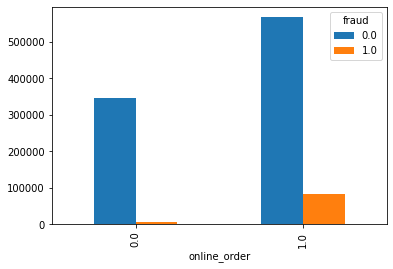

In [ ]:
pd.crosstab([df['online_order']], df['fraud']).plot.bar()

Aqui vemos que dentre as transações fraudulentas, a maioria delas ocorreu quando foi online. Isso pode indicar um comportamento em comum dos golpistas ou alguma tendência a isso acontecer pois muitas transações online garantem o anonimato.

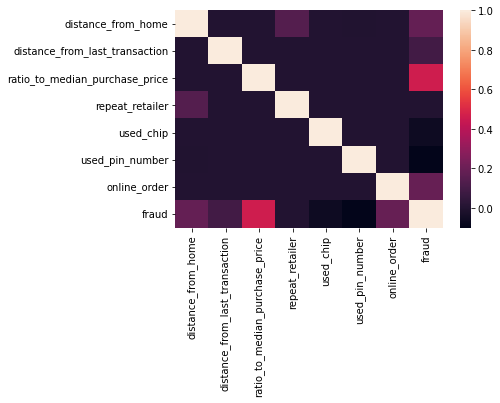

In [ ]:
sns.heatmap(df.corr())

Olhando a matriz de correlação, vemos que as features com maior correlação para uma transação fraudulenta são a taxa de variação em relação à média de compras, a distância de casa e se um pedido é online ou não. Além disso, temos que uma transação é bem mais propensa a ser fraudulenta quando ela não usa o número PIN do cartão, como mostrado na correlação baixíssima entre os dois. Sendo assim, será importante avaliarmos essas features

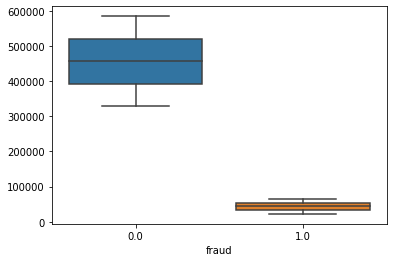

In [ ]:
dads = pd.crosstab([df['used_chip']], df['fraud'])
sns.boxplot(data=dads,orient='vertical')

Aqui, como podemos ver a maioria das transações fraudulentas ocorre sem o uso de chip. Isso é evidente pois a maioria das transações legítimas ocorreram com o uso de chip, enquanto poucas foram as transações fraudulentas que foram realizadas sem o uso de chip

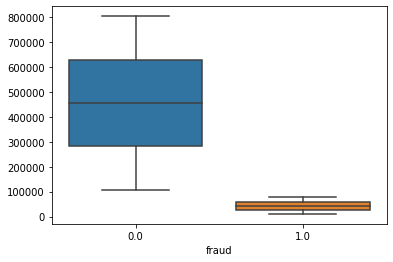

In [ ]:
dads = pd.crosstab([df['repeat_retailer']], df['fraud'])
sns.boxplot(data=dads,orient='vertical')

Esse boxplot evidencia que uma boa parte das transações legítimas ocorre com o mesmo varejista da transação anterior, enquanto aquelas fraudulentas são poucos os casos que isso ocorre, op que aponta mais uma tendência de comportamento dos fraudadores.

### **Rede Neural**

In [ ]:
from sklearn.model_selection import train_test_split
treino, teste = train_test_split(df, train_size=0.8)
features = [i for i in treino.columns[:-1]]

In [ ]:
import tensorflow
from tensorflow import keras

nn = keras.Sequential([
      keras.layers.Input(len(treino.columns)-1),
      keras.layers.Dense(4, activation='relu'),
      keras.layers.Dense(3, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
])
nn.compile(optimizer='adam' , loss='binary_crossentropy')
nn.fit(treino[features],treino['fraud'])

25000/25000 [==============================] - 41s 2ms/step - loss: 0.1042


In [ ]:
prevs = nn.predict(treino[features])
prevs

array([[1.15536146e-07],
       [2.24652831e-06],
       [1.46190596e-05],
       ...,
       [3.29328401e-07],
       [1.12468988e-05],
       [9.58617449e-01]], dtype=float32)

In [ ]:
limiar = 0.6
def ativacao(v):
  if(v < limiar):
    return 0
  return 1

prev_treino = []
for prev in prevs:
  prev_treino.append(ativacao(prev))

prev_treino[:15]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

A rede neural que foi montada possui 7 entradas, correspondentes as features da base de dados. Além disso, ela possui 2 camadas internas, uma com 4 neurônios e a outra com 3, respectivamente. Por fim, temos a camada de saída, que produz valores booleanos por meio da função de ativação. Esses valores correspondem à presença ou não de fraude na transação bancária. Para a maior eficiência do modelo, determinamos que o limiar de ativação seria 0.6.

In [ ]:
y_treino = treino['fraud']
y_treino

574454    0.0
338183    0.0
702080    0.0
913490    0.0
511482    0.0
         ... 
109263    0.0
124517    0.0
961984    0.0
441986    0.0
884940    1.0
Name: fraud, Length: 800000, dtype: float64

In [ ]:
from sklearn.metrics import accuracy_score
acuracia_treino= accuracy_score(y_treino,prev_treino)
acuracia_treino*100

97.393

Uma acurácia de treino equivalente a 97% é um sinal bem positivo, pois indica que o modelo é bem eficiente em detectar transações fraudulentas, podendo ser utilizado por alguma instituição financeira para este fim. No cenário do negócio, decisões estratégicas de segurança poderão ser tomadas com mais rapidez o que é muito bom. Agora resta saber se a acurácia em teste se manterá a mesma.

In [ ]:
previsoes = nn.predict(teste[features] )
prev_teste = []
for prev in previsoes:
  prev_teste.append(ativacao(prev))

prev_teste[:15]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
y_teste = teste['fraud']
y_teste

904998    0.0
409177    0.0
981375    0.0
384867    0.0
33290     0.0
         ... 
895661    0.0
306410    0.0
634658    0.0
545009    1.0
777197    0.0
Name: fraud, Length: 200000, dtype: float64

Aqui foram realizadas as predições porém com a parcela da base de dados correspondente ao teste (20% do total)

In [ ]:
from sklearn.metrics import accuracy_score
acuracia_teste= accuracy_score(y_teste,prev_teste)
acuracia_teste*100

97.41250000000001

A acurácia de teste se mostrou praticamente igual a de treino, o que demonstra que não houve overfit dos dados e que o modelo é muito eficiente para prever fraudes em transações com base em features específicas. Acreditamos que se alguma instituição financeira usar esse modelo junto de outros dados para apuração, o nível de segurança possa ser maior e a resposta de possiveis clonagens de cartão possa ser mais rápida e eficiente, dando mais confiança para os clientes.

[[180049   2617]
 [  2558  14776]]


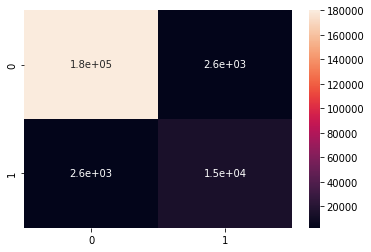

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
cm = confusion_matrix(y_teste , prev_teste)
print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_teste,prev_teste))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    182666
         1.0       0.85      0.85      0.85     17334

    accuracy                           0.97    200000
   macro avg       0.92      0.92      0.92    200000
weighted avg       0.97      0.97      0.97    200000



A matriz de confusão evidencia o que já foi descrito antes. Uma ótima porcentagem de acertos e erros, com recalls iguais à precisão em ambos (99% para negativos e 85% para positivos). Contudo, também é possível observar que o número de FN é menor que o de FP. Como dito em fases anteriores desse mesmo contexto de negócio, isso é benéfico, pois caso ocorra um FP o cliente pode recorrer à instituição e revogar o cancelamento do seu cartão. Porém, quando há um FN, não há uma medida rápida de segurança, algo que deve ser evitado a todo custo. Sendo assim, é possível concluir que o modelo é bem utilizável em um cenário real e com certeza teria uma eficiência ainda maior se fossem obtidos mais dados. No entanto ele se saiu muito bem com as features usadas aqui.